# 💊 Drug Discovery - Molecular Solubility Prediction with Graph Neural Networks

## Overview
This notebook trains a **Graph Convolutional Network (GNN)** to predict molecular solubility from SMILES strings.

**Dataset:** ESOL (Estimated Solubility)
- 1,128 molecules with measured solubility
- Task: Regression (predict log solubility)

**Architecture:** Graph Neural Network
- Nodes = atoms
- Edges = chemical bonds
- Message passing to learn molecular properties

**Expected Performance:**
- R² > 0.80
- MAE < 0.7
- Training time: 4-6 hours

## Step 1: Environment Setup

In [1]:
# Check GPU availability
import torch
import sys

print("="*70)
print("ENVIRONMENT CHECK")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  PyTorch Version: {torch.__version__}")
else:
    print("  ⚠️ No GPU detected - training will be slower!")
    print("  Consider: Runtime → Change runtime type → GPU")

print(f"\n✓ Python version: {sys.version}")

ENVIRONMENT CHECK

✓ Using device: cuda
  GPU: NVIDIA A100-SXM4-80GB
  CUDA Version: 12.6
  PyTorch Version: 2.9.0+cu126

✓ Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


## Step 2: Install Required Libraries

In [2]:
# Install RDKit for molecular processing
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 71.3 MB/s eta 0:00:00


In [3]:
# Install PyG and dependencies
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}+cu{cuda_version.replace('.', '')}.html
!pip install -q torch-geometric

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}+cu{cuda_version.replace('.', '')}.html'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00


In [4]:

# Install PyTorch Geometric for GNNs
import torch

# Get PyTorch and CUDA versions
torch_version = torch.__version__.split('+')[0]
cuda_version = torch.version.cuda

print(f"Installing PyTorch Geometric for PyTorch {torch_version}...")

print("\n✓ All libraries installed successfully!")

# Verify installations
try:
    from rdkit import Chem
    print("✓ RDKit imported")
except:
    print("❌ RDKit import failed")

try:
    import torch_geometric
    print(f"✓ PyTorch Geometric {torch_geometric.__version__} imported")
except:
    print("❌ PyTorch Geometric import failed")

Installing PyTorch Geometric for PyTorch 2.9.0...

✓ All libraries installed successfully!
✓ RDKit imported
✓ PyTorch Geometric 2.7.0 imported


## Step 3: Mount Google Drive & Load Data

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/medical-ai-project/drug-discovery')
print("✓ Working directory set to drug-discovery folder")

Mounted at /content/drive
✓ Working directory set to drug-discovery folder


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

print("="*70)
print("LOADING ESOL DATASET")
print("="*70)

data_dir = Path('./data')

# Load data splits
train_df = pd.read_csv(data_dir / 'esol_train.csv')
valid_df = pd.read_csv(data_dir / 'esol_valid.csv')
test_df = pd.read_csv(data_dir / 'esol_test.csv')

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_df):,} molecules")
print(f"  Validation: {len(valid_df):,} molecules")
print(f"  Test:       {len(test_df):,} molecules")
print(f"  Total:      {len(train_df) + len(valid_df) + len(test_df):,} molecules")

print(f"\nTarget property: Log Solubility (log mol/L)")
print(f"  Range: {train_df['measured log solubility in mols per litre'].min():.2f} to {train_df['measured log solubility in mols per litre'].max():.2f}")
print(f"  Mean: {train_df['measured log solubility in mols per litre'].mean():.2f}")
print(f"  Std: {train_df['measured log solubility in mols per litre'].std():.2f}")

print(f"\nSample SMILES:")
for i, row in train_df.head(3).iterrows():
    print(f"  {row['Compound ID']:30s} {row['smiles']:40s} → {row['measured log solubility in mols per litre']:.2f}")

print("\n✓ Data loaded successfully!")

LOADING ESOL DATASET

Dataset sizes:
  Training:   902 molecules
  Validation: 113 molecules
  Test:       113 molecules
  Total:      1,128 molecules

Target property: Log Solubility (log mol/L)
  Range: -11.60 to 1.58
  Mean: -3.04
  Std: 2.08

Sample SMILES:
  3,5-Dimethylphenol             Cc1cc(C)cc(O)c1                          → -1.40
  Methyl propyl ether            CCCOC                                    → -0.39
  2-Bromonapthalene              Brc1ccc2ccccc2c1                         → -4.40

✓ Data loaded successfully!


## Step 4: Convert SMILES to Molecular Graphs

**Graph Representation:**
- **Nodes:** Atoms (C, O, N, H, etc.)
- **Edges:** Chemical bonds (single, double, triple, aromatic)
- **Node Features:** Atom type, charge, hybridization, aromaticity
- **Edge Features:** Bond type, conjugation

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data
from tqdm import tqdm

# Define atom feature extraction
def get_atom_features(atom):
    """
    Extract features for a single atom

    Returns:
        List of numerical features (length 9)
    """
    # One-hot encoding of atom type (C, N, O, F, etc.)
    atom_type = [0] * 10  # Support top 10 atom types
    atom_symbol = atom.GetSymbol()
    symbol_to_idx = {'C': 0, 'N': 1, 'O': 2, 'F': 3, 'S': 4, 'Cl': 5, 'Br': 6, 'I': 7, 'P': 8}
    if atom_symbol in symbol_to_idx:
        atom_type[symbol_to_idx[atom_symbol]] = 1
    else:
        atom_type[9] = 1  # "Other"

    # Additional features
    features = atom_type + [
        atom.GetTotalDegree() / 5.0,  # Normalized degree
        atom.GetFormalCharge(),        # Formal charge
        atom.GetNumRadicalElectrons(), # Radical electrons
        atom.GetIsAromatic(),          # Aromaticity
        atom.IsInRing(),               # In ring
    ]

    return features

def smiles_to_graph(smiles):
    """
    Convert SMILES string to PyTorch Geometric graph

    Args:
        smiles: SMILES string

    Returns:
        torch_geometric.data.Data object
    """
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        # Invalid SMILES - return empty graph
        return None

    # Get atom features (nodes)
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))

    x = torch.tensor(atom_features, dtype=torch.float)

    # Get bond information (edges)
    edge_indices = []
    edge_features = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_indices.append([j, i])

        # Bond features (bond type)
        bond_type = [0] * 4
        bond_type_map = {
            Chem.rdchem.BondType.SINGLE: 0,
            Chem.rdchem.BondType.DOUBLE: 1,
            Chem.rdchem.BondType.TRIPLE: 2,
            Chem.rdchem.BondType.AROMATIC: 3
        }
        if bond.GetBondType() in bond_type_map:
            bond_type[bond_type_map[bond.GetBondType()]] = 1

        edge_features.append(bond_type)
        edge_features.append(bond_type)  # Same for reverse edge

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr
    )

    return data

print("✓ Graph conversion functions defined")

# Test on one molecule
test_smiles = train_df.iloc[0]['smiles']
test_graph = smiles_to_graph(test_smiles)

print(f"\nTest conversion:")
print(f"  SMILES: {test_smiles}")
print(f"  Graph: {test_graph}")
print(f"  Number of atoms (nodes): {test_graph.x.shape[0]}")
print(f"  Number of bonds (edges): {test_graph.edge_index.shape[1]}")
print(f"  Node feature dimension: {test_graph.x.shape[1]}")

✓ Graph conversion functions defined

Test conversion:
  SMILES: Cc1cc(C)cc(O)c1
  Graph: Data(x=[9, 15], edge_index=[2, 18], edge_attr=[18, 4])
  Number of atoms (nodes): 9
  Number of bonds (edges): 18
  Node feature dimension: 15


## Step 5: Create PyTorch Geometric Datasets

In [8]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

class MoleculeDataset(InMemoryDataset):
    def __init__(self, df, transform=None, pre_transform=None):
        self.df = df
        super().__init__('.', transform, pre_transform)
        self.data, self.slices = self.process_data()

    def process_data(self):
        data_list = []

        print(f"Converting {len(self.df)} molecules to graphs...")

        for idx, row in tqdm(self.df.iterrows(), total=len(self.df)):
            smiles = row['smiles']
            target = row['measured log solubility in mols per litre']

            # Convert SMILES to graph
            graph = smiles_to_graph(smiles)

            if graph is not None:
                # Add target (solubility value)
                graph.y = torch.tensor([target], dtype=torch.float)
                data_list.append(graph)

        print(f"✓ Successfully converted {len(data_list)}/{len(self.df)} molecules")

        return self.collate(data_list)

    def len(self):
        return self.slices['x'].size(0) - 1

    def get(self, idx):
        data = Data()
        for key in self.data.keys():
            item, slices = self.data[key], self.slices[key]
            s = list(repeat(slice(None), item.dim()))
            s[data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        return data

# Import repeat for get method
from itertools import repeat

print("="*70)
print("CREATING GRAPH DATASETS")
print("="*70)

# Create datasets
print("\nProcessing training set...")
train_dataset = MoleculeDataset(train_df)

print("\nProcessing validation set...")
valid_dataset = MoleculeDataset(valid_df)

print("\nProcessing test set...")
test_dataset = MoleculeDataset(test_df)

print("\n" + "="*70)
print("DATASET SUMMARY")
print("="*70)
print(f"  Training graphs:   {len(train_dataset):,}")
print(f"  Validation graphs: {len(valid_dataset):,}")
print(f"  Test graphs:       {len(test_dataset):,}")
print(f"  Node feature dim:  {train_dataset[0].x.shape[1]}")
print(f"  Edge feature dim:  {train_dataset[0].edge_attr.shape[1]}")

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ DataLoaders created (batch size: {BATCH_SIZE})")
print(f"  Training batches:   {len(train_loader)}")
print(f"  Validation batches: {len(valid_loader)}")
print(f"  Test batches:       {len(test_loader)}")

CREATING GRAPH DATASETS

Processing training set...
Converting 902 molecules to graphs...


100%|██████████| 902/902 [00:00<00:00, 1631.13it/s]


✓ Successfully converted 902/902 molecules

Processing validation set...
Converting 113 molecules to graphs...


100%|██████████| 113/113 [00:00<00:00, 1620.41it/s]


✓ Successfully converted 113/113 molecules

Processing test set...
Converting 113 molecules to graphs...


100%|██████████| 113/113 [00:00<00:00, 1743.74it/s]

✓ Successfully converted 113/113 molecules

DATASET SUMMARY
  Training graphs:   902
  Validation graphs: 113
  Test graphs:       113
  Node feature dim:  15
  Edge feature dim:  4

✓ DataLoaders created (batch size: 32)
  Training batches:   29
  Validation batches: 4
  Test batches:       4



/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be

## Step 6: Define Graph Neural Network Architecture

**Architecture:** Graph Convolutional Network (GCN)
- 3 GCN layers with message passing
- Global mean pooling (aggregate atom features)
- MLP head for regression

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class MolecularGNN(nn.Module):
    """
    Graph Convolutional Network for molecular property prediction

    Architecture:
    1. Graph Convolution Layers (message passing between atoms)
    2. Global Pooling (aggregate to molecule-level representation)
    3. MLP Head (predict solubility)
    """
    def __init__(self, node_feature_dim, hidden_dim=128, num_layers=3, dropout=0.2):
        super(MolecularGNN, self).__init__()

        self.num_layers = num_layers

        # Graph convolutional layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer: node_features → hidden_dim
        self.convs.append(GCNConv(node_feature_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Middle layers: hidden_dim → hidden_dim
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Last layer: hidden_dim → hidden_dim
        self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # MLP head for regression
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, 1)  # Output: single value (solubility)
        )

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Graph convolution layers with residual connections
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_new = conv(x, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)

            # Residual connection (if dimensions match)
            if i > 0 and x.shape[1] == x_new.shape[1]:
                x = x + x_new
            else:
                x = x_new

        # Global pooling (molecule-level representation)
        x = global_mean_pool(x, batch)

        # MLP head for prediction
        x = self.mlp(x)

        return x

# Create model
node_feature_dim = train_dataset[0].x.shape[1]

model = MolecularGNN(
    node_feature_dim=node_feature_dim,
    hidden_dim=128,
    num_layers=3,
    dropout=0.2
).to(device)

print("="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print(f"\nModel parameters:")
print(f"  Total: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
test_batch = next(iter(train_loader))
test_batch = test_batch.to(device)
with torch.no_grad():
    test_output = model(test_batch)

print(f"\nTest forward pass:")
print(f"  Input: {len(test_batch)} molecules")
print(f"  Output shape: {test_output.shape}")
print(f"  Sample predictions: {test_output[:3].squeeze().cpu().numpy()}")

print("\n✓ Model created successfully!")

/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be 

MODEL ARCHITECTURE
MolecularGNN(
  (convs): ModuleList(
    (0): GCNConv(15, 128)
    (1-2): 2 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Model parameters:
  Total: 46,209
  Trainable: 46,209

Test forward pass:
  Input: 32 molecules
  Output shape: torch.Size([32, 1])
  Sample predictions: [0.14449738 0.39963433 0.23832425]

✓ Model created successfully!


## Step 7: Training Setup

In [10]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
PATIENCE = 30  # Early stopping patience

# Loss function (MSE for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=10, factor=0.5, min_lr=1e-6
)

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"  Loss function: MSE (Mean Squared Error)")
print(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay=1e-5)")
print(f"  Scheduler: ReduceLROnPlateau (patience=10, factor=0.5)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping: {PATIENCE} epochs without improvement")
print(f"  Device: {device}")

TRAINING CONFIGURATION
  Loss function: MSE (Mean Squared Error)
  Optimizer: Adam (lr=0.001, weight_decay=1e-5)
  Scheduler: ReduceLROnPlateau (patience=10, factor=0.5)
  Batch size: 32
  Max epochs: 200
  Early stopping: 30 epochs without improvement
  Device: cuda


## Step 8: Training & Validation Functions

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
      model.train()
      total_loss = 0
      all_preds = []
      all_targets = []

      for batch in tqdm(loader, desc='Training', leave=False):
          batch = batch.to(device)

          optimizer.zero_grad()
          predictions = model(batch)
          loss = criterion(predictions.squeeze(), batch.y)  # ← FIXED: Added .squeeze()

          loss.backward()
          optimizer.step()

          total_loss += loss.item() * batch.num_graphs
          all_preds.extend(predictions.squeeze().detach().cpu().numpy())  # ← FIXED: Added .squeeze()
          all_targets.extend(batch.y.detach().cpu().numpy())

      avg_loss = total_loss / len(loader.dataset)

      # Calculate metrics
      all_preds = np.array(all_preds).flatten()
      all_targets = np.array(all_targets).flatten()

      mae = mean_absolute_error(all_targets, all_preds)
      rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
      r2 = r2_score(all_targets, all_preds)

      return avg_loss, mae, rmse, r2

def validate_epoch(model, loader, criterion, device):
      model.eval()
      total_loss = 0
      all_preds = []
      all_targets = []

      with torch.no_grad():
          for batch in tqdm(loader, desc='Validation', leave=False):
              batch = batch.to(device)

              predictions = model(batch)
              loss = criterion(predictions.squeeze(), batch.y)  # ← FIXED: Added .squeeze()

              total_loss += loss.item() * batch.num_graphs
              all_preds.extend(predictions.squeeze().cpu().numpy())  # ← FIXED: Added .squeeze()
              all_targets.extend(batch.y.cpu().numpy())

      avg_loss = total_loss / len(loader.dataset)

      # Calculate metrics
      all_preds = np.array(all_preds).flatten()
      all_targets = np.array(all_targets).flatten()

      mae = mean_absolute_error(all_targets, all_preds)
      rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
      r2 = r2_score(all_targets, all_preds)

      return avg_loss, mae, rmse, r2, all_preds, all_targets

print("✓ Training functions defined")

✓ Training functions defined


## Step 9: Training Loop

In [14]:
import os

# Create models directory
os.makedirs('./models', exist_ok=True)

best_r2 = -float('inf')
best_model_path = './models/best_drug_discovery_GNN_model.pth'
patience_counter = 0

history = {
    'train_loss': [], 'train_mae': [], 'train_rmse': [], 'train_r2': [],
    'val_loss': [], 'val_mae': [], 'val_rmse': [], 'val_r2': []
}

print("="*70)
print(f"STARTING TRAINING - UP TO {NUM_EPOCHS} EPOCHS")
print("="*70)
print(f"Training on {len(train_dataset)} molecules")
print(f"Validating on {len(valid_dataset)} molecules")
print(f"Model will save to: {best_model_path}")
print("="*70)

for epoch in range(NUM_EPOCHS):
    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Training
    train_loss, train_mae, train_rmse, train_r2 = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation
    val_loss, val_mae, val_rmse, val_r2, _, _ = validate_epoch(
        model, valid_loader, criterion, device
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['train_rmse'].append(train_rmse)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)

    # Print metrics
    print(f"Train - Loss: {train_loss:.4f} | MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f} | R²: {train_r2:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f} | R²: {val_r2:.4f}")

    # Update learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Best model saved! R² = {best_r2:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Best R²: {best_r2:.4f}")
        break

print("\n" + "="*70)
print("🎉 TRAINING COMPLETE!")
print("="*70)
print(f"Best validation R²: {best_r2:.4f}")
print(f"Best validation MAE: {min(history['val_mae']):.4f}")
print(f"Best validation RMSE: {min(history['val_rmse']):.4f}")

STARTING TRAINING - UP TO 200 EPOCHS
Training on 902 molecules
Validating on 113 molecules
Model will save to: ./models/best_drug_discovery_GNN_model.pth

📊 Epoch 1/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 7.9131 | MAE: 2.2402 | RMSE: 2.8130 | R²: -0.8373
Val   - Loss: 7.2300 | MAE: 2.0646 | RMSE: 2.6889 | R²: -0.4029
✓ Best model saved! R² = -0.4029

📊 Epoch 2/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.7884 | MAE: 1.5477 | RMSE: 1.9464 | R²: 0.1204
Val   - Loss: 4.5426 | MAE: 1.6340 | RMSE: 2.1313 | R²: 0.1186
✓ Best model saved! R² = 0.1186

📊 Epoch 3/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.3995 | MAE: 1.4575 | RMSE: 1.8438 | R²: 0.2107
Val   - Loss: 3.3493 | MAE: 1.4237 | RMSE: 1.8301 | R²: 0.3501
✓ Best model saved! R² = 0.3501

📊 Epoch 4/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.2589 | MAE: 1.4138 | RMSE: 1.8052 | R²: 0.2433
Val   - Loss: 3.4738 | MAE: 1.4277 | RMSE: 1.8638 | R²: 0.3260

📊 Epoch 5/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.1765 | MAE: 1.3985 | RMSE: 1.7823 | R²: 0.2625
Val   - Loss: 3.1250 | MAE: 1.3669 | RMSE: 1.7678 | R²: 0.3936
✓ Best model saved! R² = 0.3936

📊 Epoch 6/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.1718 | MAE: 1.3943 | RMSE: 1.7810 | R²: 0.2636
Val   - Loss: 4.0701 | MAE: 1.4861 | RMSE: 2.0174 | R²: 0.2103

📊 Epoch 7/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.0154 | MAE: 1.3711 | RMSE: 1.7365 | R²: 0.2999
Val   - Loss: 3.3301 | MAE: 1.3872 | RMSE: 1.8249 | R²: 0.3538

📊 Epoch 8/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.9899 | MAE: 1.3507 | RMSE: 1.7291 | R²: 0.3058
Val   - Loss: 3.2465 | MAE: 1.3742 | RMSE: 1.8018 | R²: 0.3701

📊 Epoch 9/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 3.0262 | MAE: 1.3452 | RMSE: 1.7396 | R²: 0.2974
Val   - Loss: 3.2478 | MAE: 1.3837 | RMSE: 1.8022 | R²: 0.3698

📊 Epoch 10/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.7324 | MAE: 1.2900 | RMSE: 1.6530 | R²: 0.3656
Val   - Loss: 3.0183 | MAE: 1.3531 | RMSE: 1.7373 | R²: 0.4144
✓ Best model saved! R² = 0.4144

📊 Epoch 11/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.9009 | MAE: 1.3119 | RMSE: 1.7032 | R²: 0.3265
Val   - Loss: 3.0517 | MAE: 1.3755 | RMSE: 1.7469 | R²: 0.4079

📊 Epoch 12/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.8344 | MAE: 1.3171 | RMSE: 1.6836 | R²: 0.3419
Val   - Loss: 3.1506 | MAE: 1.3456 | RMSE: 1.7750 | R²: 0.3887

📊 Epoch 13/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.9312 | MAE: 1.3335 | RMSE: 1.7121 | R²: 0.3194
Val   - Loss: 3.0353 | MAE: 1.3390 | RMSE: 1.7422 | R²: 0.4111

📊 Epoch 14/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6277 | MAE: 1.2499 | RMSE: 1.6210 | R²: 0.3899
Val   - Loss: 3.3846 | MAE: 1.3874 | RMSE: 1.8397 | R²: 0.3433

📊 Epoch 15/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.7747 | MAE: 1.2903 | RMSE: 1.6657 | R²: 0.3558
Val   - Loss: 3.2558 | MAE: 1.3532 | RMSE: 1.8044 | R²: 0.3683

📊 Epoch 16/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5901 | MAE: 1.2487 | RMSE: 1.6094 | R²: 0.3986
Val   - Loss: 2.7378 | MAE: 1.2758 | RMSE: 1.6546 | R²: 0.4688
✓ Best model saved! R² = 0.4688

📊 Epoch 17/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6523 | MAE: 1.2515 | RMSE: 1.6286 | R²: 0.3842
Val   - Loss: 3.0993 | MAE: 1.3326 | RMSE: 1.7605 | R²: 0.3986

📊 Epoch 18/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6229 | MAE: 1.2519 | RMSE: 1.6195 | R²: 0.3910
Val   - Loss: 3.0823 | MAE: 1.3321 | RMSE: 1.7557 | R²: 0.4019

📊 Epoch 19/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6247 | MAE: 1.2691 | RMSE: 1.6201 | R²: 0.3906
Val   - Loss: 2.7681 | MAE: 1.2883 | RMSE: 1.6638 | R²: 0.4629

📊 Epoch 20/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6590 | MAE: 1.2722 | RMSE: 1.6306 | R²: 0.3826
Val   - Loss: 2.9082 | MAE: 1.2833 | RMSE: 1.7053 | R²: 0.4357

📊 Epoch 21/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6655 | MAE: 1.2727 | RMSE: 1.6326 | R²: 0.3811
Val   - Loss: 2.7615 | MAE: 1.2791 | RMSE: 1.6618 | R²: 0.4642

📊 Epoch 22/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6503 | MAE: 1.2655 | RMSE: 1.6280 | R²: 0.3847
Val   - Loss: 3.3397 | MAE: 1.3550 | RMSE: 1.8275 | R²: 0.3520

📊 Epoch 23/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.7614 | MAE: 1.2602 | RMSE: 1.6618 | R²: 0.3588
Val   - Loss: 2.9349 | MAE: 1.3062 | RMSE: 1.7132 | R²: 0.4305

📊 Epoch 24/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5794 | MAE: 1.2217 | RMSE: 1.6061 | R²: 0.4011
Val   - Loss: 2.5016 | MAE: 1.2361 | RMSE: 1.5816 | R²: 0.5146
✓ Best model saved! R² = 0.5146

📊 Epoch 25/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4608 | MAE: 1.2194 | RMSE: 1.5687 | R²: 0.4286
Val   - Loss: 2.5945 | MAE: 1.2384 | RMSE: 1.6108 | R²: 0.4966

📊 Epoch 26/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6606 | MAE: 1.2747 | RMSE: 1.6311 | R²: 0.3823
Val   - Loss: 2.5956 | MAE: 1.2431 | RMSE: 1.6111 | R²: 0.4964

📊 Epoch 27/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4027 | MAE: 1.1877 | RMSE: 1.5501 | R²: 0.4421
Val   - Loss: 2.5429 | MAE: 1.2449 | RMSE: 1.5946 | R²: 0.5066

📊 Epoch 28/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5477 | MAE: 1.2417 | RMSE: 1.5961 | R²: 0.4085
Val   - Loss: 2.4100 | MAE: 1.2130 | RMSE: 1.5524 | R²: 0.5324
✓ Best model saved! R² = 0.5324

📊 Epoch 29/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4359 | MAE: 1.1834 | RMSE: 1.5607 | R²: 0.4344
Val   - Loss: 2.7869 | MAE: 1.2359 | RMSE: 1.6694 | R²: 0.4593

📊 Epoch 30/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4871 | MAE: 1.2193 | RMSE: 1.5771 | R²: 0.4225
Val   - Loss: 2.4602 | MAE: 1.1982 | RMSE: 1.5685 | R²: 0.5226

📊 Epoch 31/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5052 | MAE: 1.2180 | RMSE: 1.5828 | R²: 0.4183
Val   - Loss: 2.4407 | MAE: 1.1888 | RMSE: 1.5623 | R²: 0.5264

📊 Epoch 32/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4118 | MAE: 1.1918 | RMSE: 1.5530 | R²: 0.4400
Val   - Loss: 2.5505 | MAE: 1.2038 | RMSE: 1.5970 | R²: 0.5051

📊 Epoch 33/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5409 | MAE: 1.2260 | RMSE: 1.5940 | R²: 0.4100
Val   - Loss: 2.7690 | MAE: 1.2630 | RMSE: 1.6640 | R²: 0.4627

📊 Epoch 34/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.6437 | MAE: 1.2368 | RMSE: 1.6260 | R²: 0.3862
Val   - Loss: 2.5410 | MAE: 1.2406 | RMSE: 1.5940 | R²: 0.5070

📊 Epoch 35/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4349 | MAE: 1.2045 | RMSE: 1.5604 | R²: 0.4347
Val   - Loss: 2.5410 | MAE: 1.1987 | RMSE: 1.5941 | R²: 0.5070

📊 Epoch 36/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4686 | MAE: 1.2052 | RMSE: 1.5712 | R²: 0.4268
Val   - Loss: 2.4147 | MAE: 1.1962 | RMSE: 1.5539 | R²: 0.5315

📊 Epoch 37/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3037 | MAE: 1.1677 | RMSE: 1.5178 | R²: 0.4651
Val   - Loss: 2.2759 | MAE: 1.1570 | RMSE: 1.5086 | R²: 0.5584
✓ Best model saved! R² = 0.5584

📊 Epoch 38/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4035 | MAE: 1.2095 | RMSE: 1.5503 | R²: 0.4419
Val   - Loss: 2.3473 | MAE: 1.1673 | RMSE: 1.5321 | R²: 0.5445

📊 Epoch 39/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3281 | MAE: 1.1812 | RMSE: 1.5258 | R²: 0.4595
Val   - Loss: 2.1759 | MAE: 1.1260 | RMSE: 1.4751 | R²: 0.5778
✓ Best model saved! R² = 0.5778

📊 Epoch 40/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5261 | MAE: 1.2157 | RMSE: 1.5894 | R²: 0.4135
Val   - Loss: 2.2855 | MAE: 1.1554 | RMSE: 1.5118 | R²: 0.5565

📊 Epoch 41/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3135 | MAE: 1.1758 | RMSE: 1.5210 | R²: 0.4628
Val   - Loss: 2.4296 | MAE: 1.1702 | RMSE: 1.5587 | R²: 0.5286

📊 Epoch 42/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3531 | MAE: 1.1773 | RMSE: 1.5340 | R²: 0.4536
Val   - Loss: 2.3764 | MAE: 1.1929 | RMSE: 1.5415 | R²: 0.5389

📊 Epoch 43/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3542 | MAE: 1.1868 | RMSE: 1.5343 | R²: 0.4534
Val   - Loss: 2.4219 | MAE: 1.1600 | RMSE: 1.5562 | R²: 0.5301

📊 Epoch 44/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3174 | MAE: 1.1742 | RMSE: 1.5223 | R²: 0.4619
Val   - Loss: 2.4401 | MAE: 1.1981 | RMSE: 1.5621 | R²: 0.5265

📊 Epoch 45/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3001 | MAE: 1.1588 | RMSE: 1.5166 | R²: 0.4660
Val   - Loss: 2.2620 | MAE: 1.1828 | RMSE: 1.5040 | R²: 0.5611

📊 Epoch 46/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4984 | MAE: 1.2114 | RMSE: 1.5806 | R²: 0.4199
Val   - Loss: 2.3915 | MAE: 1.1844 | RMSE: 1.5464 | R²: 0.5360

📊 Epoch 47/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.5039 | MAE: 1.2210 | RMSE: 1.5824 | R²: 0.4186
Val   - Loss: 2.2129 | MAE: 1.1408 | RMSE: 1.4876 | R²: 0.5706

📊 Epoch 48/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3718 | MAE: 1.1993 | RMSE: 1.5401 | R²: 0.4493
Val   - Loss: 2.4929 | MAE: 1.2030 | RMSE: 1.5789 | R²: 0.5163

📊 Epoch 49/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2511 | MAE: 1.1825 | RMSE: 1.5004 | R²: 0.4773
Val   - Loss: 2.2326 | MAE: 1.1388 | RMSE: 1.4942 | R²: 0.5668

📊 Epoch 50/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4131 | MAE: 1.1945 | RMSE: 1.5534 | R²: 0.4397
Val   - Loss: 2.3829 | MAE: 1.1366 | RMSE: 1.5437 | R²: 0.5376

📊 Epoch 51/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1733 | MAE: 1.1391 | RMSE: 1.4742 | R²: 0.4954
Val   - Loss: 2.1549 | MAE: 1.1266 | RMSE: 1.4680 | R²: 0.5819
✓ Best model saved! R² = 0.5819

📊 Epoch 52/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2816 | MAE: 1.1471 | RMSE: 1.5105 | R²: 0.4702
Val   - Loss: 2.2065 | MAE: 1.1386 | RMSE: 1.4854 | R²: 0.5719

📊 Epoch 53/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2501 | MAE: 1.1453 | RMSE: 1.5000 | R²: 0.4776
Val   - Loss: 2.4407 | MAE: 1.1798 | RMSE: 1.5623 | R²: 0.5264

📊 Epoch 54/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2210 | MAE: 1.1357 | RMSE: 1.4903 | R²: 0.4843
Val   - Loss: 2.3467 | MAE: 1.1570 | RMSE: 1.5319 | R²: 0.5447

📊 Epoch 55/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3097 | MAE: 1.1839 | RMSE: 1.5198 | R²: 0.4637
Val   - Loss: 2.2215 | MAE: 1.1153 | RMSE: 1.4905 | R²: 0.5690

📊 Epoch 56/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0946 | MAE: 1.0954 | RMSE: 1.4473 | R²: 0.5137
Val   - Loss: 2.4147 | MAE: 1.1584 | RMSE: 1.5539 | R²: 0.5315

📊 Epoch 57/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2709 | MAE: 1.1516 | RMSE: 1.5069 | R²: 0.4727
Val   - Loss: 2.3480 | MAE: 1.1353 | RMSE: 1.5323 | R²: 0.5444

📊 Epoch 58/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2278 | MAE: 1.1585 | RMSE: 1.4926 | R²: 0.4828
Val   - Loss: 2.3257 | MAE: 1.1340 | RMSE: 1.5250 | R²: 0.5487

📊 Epoch 59/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.4234 | MAE: 1.1909 | RMSE: 1.5567 | R²: 0.4373
Val   - Loss: 2.3722 | MAE: 1.1372 | RMSE: 1.5402 | R²: 0.5397

📊 Epoch 60/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.3063 | MAE: 1.1625 | RMSE: 1.5186 | R²: 0.4645
Val   - Loss: 2.3725 | MAE: 1.1359 | RMSE: 1.5403 | R²: 0.5397

📊 Epoch 61/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1373 | MAE: 1.1331 | RMSE: 1.4620 | R²: 0.5037
Val   - Loss: 2.1893 | MAE: 1.1021 | RMSE: 1.4796 | R²: 0.5752

📊 Epoch 62/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2786 | MAE: 1.1483 | RMSE: 1.5095 | R²: 0.4709
Val   - Loss: 2.1827 | MAE: 1.1553 | RMSE: 1.4774 | R²: 0.5765

📊 Epoch 63/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0153 | MAE: 1.0853 | RMSE: 1.4196 | R²: 0.5321
Val   - Loss: 2.1770 | MAE: 1.1260 | RMSE: 1.4755 | R²: 0.5776

📊 Epoch 64/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1336 | MAE: 1.1336 | RMSE: 1.4607 | R²: 0.5046
Val   - Loss: 2.1842 | MAE: 1.1074 | RMSE: 1.4779 | R²: 0.5762

📊 Epoch 65/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0030 | MAE: 1.0753 | RMSE: 1.4153 | R²: 0.5349
Val   - Loss: 2.0958 | MAE: 1.0947 | RMSE: 1.4477 | R²: 0.5933
✓ Best model saved! R² = 0.5933

📊 Epoch 66/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2015 | MAE: 1.1210 | RMSE: 1.4837 | R²: 0.4888
Val   - Loss: 2.0729 | MAE: 1.0905 | RMSE: 1.4397 | R²: 0.5978
✓ Best model saved! R² = 0.5978

📊 Epoch 67/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9264 | MAE: 1.0586 | RMSE: 1.3880 | R²: 0.5527
Val   - Loss: 2.0464 | MAE: 1.0849 | RMSE: 1.4305 | R²: 0.6029
✓ Best model saved! R² = 0.6029

📊 Epoch 68/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.2606 | MAE: 1.1383 | RMSE: 1.5035 | R²: 0.4751
Val   - Loss: 2.0471 | MAE: 1.0767 | RMSE: 1.4308 | R²: 0.6028

📊 Epoch 69/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1776 | MAE: 1.1162 | RMSE: 1.4757 | R²: 0.4944
Val   - Loss: 2.0489 | MAE: 1.0855 | RMSE: 1.4314 | R²: 0.6025

📊 Epoch 70/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0744 | MAE: 1.1062 | RMSE: 1.4403 | R²: 0.5184
Val   - Loss: 2.0979 | MAE: 1.0951 | RMSE: 1.4484 | R²: 0.5929

📊 Epoch 71/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9328 | MAE: 1.0846 | RMSE: 1.3902 | R²: 0.5512
Val   - Loss: 2.1597 | MAE: 1.1022 | RMSE: 1.4696 | R²: 0.5809

📊 Epoch 72/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0402 | MAE: 1.0845 | RMSE: 1.4283 | R²: 0.5263
Val   - Loss: 2.0499 | MAE: 1.0854 | RMSE: 1.4318 | R²: 0.6022

📊 Epoch 73/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0401 | MAE: 1.0914 | RMSE: 1.4283 | R²: 0.5263
Val   - Loss: 2.0398 | MAE: 1.0818 | RMSE: 1.4282 | R²: 0.6042
✓ Best model saved! R² = 0.6042

📊 Epoch 74/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0929 | MAE: 1.1151 | RMSE: 1.4467 | R²: 0.5141
Val   - Loss: 2.0651 | MAE: 1.0908 | RMSE: 1.4371 | R²: 0.5993

📊 Epoch 75/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0799 | MAE: 1.1169 | RMSE: 1.4422 | R²: 0.5171
Val   - Loss: 2.0321 | MAE: 1.0783 | RMSE: 1.4255 | R²: 0.6057
✓ Best model saved! R² = 0.6057

📊 Epoch 76/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0656 | MAE: 1.0737 | RMSE: 1.4372 | R²: 0.5204
Val   - Loss: 2.0898 | MAE: 1.0894 | RMSE: 1.4456 | R²: 0.5945

📊 Epoch 77/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9711 | MAE: 1.0728 | RMSE: 1.4040 | R²: 0.5423
Val   - Loss: 1.9489 | MAE: 1.0772 | RMSE: 1.3960 | R²: 0.6218
✓ Best model saved! R² = 0.6218

📊 Epoch 78/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1160 | MAE: 1.1266 | RMSE: 1.4547 | R²: 0.5087
Val   - Loss: 2.0849 | MAE: 1.0791 | RMSE: 1.4439 | R²: 0.5955

📊 Epoch 79/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1227 | MAE: 1.1238 | RMSE: 1.4569 | R²: 0.5071
Val   - Loss: 1.9642 | MAE: 1.0799 | RMSE: 1.4015 | R²: 0.6189

📊 Epoch 80/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1095 | MAE: 1.1073 | RMSE: 1.4524 | R²: 0.5102
Val   - Loss: 1.9786 | MAE: 1.0853 | RMSE: 1.4066 | R²: 0.6161

📊 Epoch 81/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0511 | MAE: 1.0827 | RMSE: 1.4321 | R²: 0.5238
Val   - Loss: 1.9518 | MAE: 1.0639 | RMSE: 1.3971 | R²: 0.6213

📊 Epoch 82/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0623 | MAE: 1.1004 | RMSE: 1.4361 | R²: 0.5212
Val   - Loss: 2.0652 | MAE: 1.0676 | RMSE: 1.4371 | R²: 0.5993

📊 Epoch 83/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9166 | MAE: 1.0649 | RMSE: 1.3844 | R²: 0.5550
Val   - Loss: 2.0269 | MAE: 1.1171 | RMSE: 1.4237 | R²: 0.6067

📊 Epoch 84/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1338 | MAE: 1.1115 | RMSE: 1.4607 | R²: 0.5046
Val   - Loss: 1.9421 | MAE: 1.0604 | RMSE: 1.3936 | R²: 0.6232
✓ Best model saved! R² = 0.6232

📊 Epoch 85/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9629 | MAE: 1.0842 | RMSE: 1.4010 | R²: 0.5443
Val   - Loss: 1.9944 | MAE: 1.0792 | RMSE: 1.4122 | R²: 0.6130

📊 Epoch 86/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1588 | MAE: 1.1031 | RMSE: 1.4693 | R²: 0.4988
Val   - Loss: 2.0107 | MAE: 1.0833 | RMSE: 1.4180 | R²: 0.6099

📊 Epoch 87/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9958 | MAE: 1.0884 | RMSE: 1.4127 | R²: 0.5366
Val   - Loss: 1.9670 | MAE: 1.0804 | RMSE: 1.4025 | R²: 0.6183

📊 Epoch 88/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0945 | MAE: 1.0983 | RMSE: 1.4472 | R²: 0.5137
Val   - Loss: 2.0353 | MAE: 1.0670 | RMSE: 1.4266 | R²: 0.6051

📊 Epoch 89/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0054 | MAE: 1.0783 | RMSE: 1.4161 | R²: 0.5344
Val   - Loss: 2.0300 | MAE: 1.0815 | RMSE: 1.4248 | R²: 0.6061

📊 Epoch 90/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1307 | MAE: 1.1217 | RMSE: 1.4597 | R²: 0.5053
Val   - Loss: 1.9914 | MAE: 1.0646 | RMSE: 1.4112 | R²: 0.6136

📊 Epoch 91/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0709 | MAE: 1.1083 | RMSE: 1.4391 | R²: 0.5192
Val   - Loss: 1.9680 | MAE: 1.0832 | RMSE: 1.4029 | R²: 0.6181

📊 Epoch 92/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0575 | MAE: 1.0836 | RMSE: 1.4344 | R²: 0.5223
Val   - Loss: 1.8787 | MAE: 1.0471 | RMSE: 1.3707 | R²: 0.6355
✓ Best model saved! R² = 0.6355

📊 Epoch 93/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9904 | MAE: 1.0623 | RMSE: 1.4108 | R²: 0.5379
Val   - Loss: 1.8678 | MAE: 1.0616 | RMSE: 1.3667 | R²: 0.6376
✓ Best model saved! R² = 0.6376

📊 Epoch 94/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1304 | MAE: 1.1094 | RMSE: 1.4596 | R²: 0.5054
Val   - Loss: 1.9026 | MAE: 1.0487 | RMSE: 1.3793 | R²: 0.6308

📊 Epoch 95/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9469 | MAE: 1.0519 | RMSE: 1.3953 | R²: 0.5480
Val   - Loss: 1.9273 | MAE: 1.0560 | RMSE: 1.3883 | R²: 0.6260

📊 Epoch 96/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0759 | MAE: 1.0853 | RMSE: 1.4408 | R²: 0.5180
Val   - Loss: 1.9392 | MAE: 1.0706 | RMSE: 1.3925 | R²: 0.6237

📊 Epoch 97/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0766 | MAE: 1.1088 | RMSE: 1.4411 | R²: 0.5178
Val   - Loss: 1.9943 | MAE: 1.0866 | RMSE: 1.4122 | R²: 0.6130

📊 Epoch 98/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9388 | MAE: 1.0511 | RMSE: 1.3924 | R²: 0.5498
Val   - Loss: 1.9665 | MAE: 1.0587 | RMSE: 1.4023 | R²: 0.6184

📊 Epoch 99/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1998 | MAE: 1.1325 | RMSE: 1.4832 | R²: 0.4893
Val   - Loss: 1.9754 | MAE: 1.0916 | RMSE: 1.4055 | R²: 0.6167

📊 Epoch 100/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0437 | MAE: 1.0899 | RMSE: 1.4296 | R²: 0.5255
Val   - Loss: 1.9531 | MAE: 1.0792 | RMSE: 1.3975 | R²: 0.6210

📊 Epoch 101/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1012 | MAE: 1.1114 | RMSE: 1.4496 | R²: 0.5121
Val   - Loss: 1.9179 | MAE: 1.0575 | RMSE: 1.3849 | R²: 0.6279

📊 Epoch 102/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0718 | MAE: 1.0965 | RMSE: 1.4394 | R²: 0.5190
Val   - Loss: 1.9206 | MAE: 1.0590 | RMSE: 1.3858 | R²: 0.6273

📊 Epoch 103/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0371 | MAE: 1.0882 | RMSE: 1.4273 | R²: 0.5270
Val   - Loss: 1.9035 | MAE: 1.0624 | RMSE: 1.3797 | R²: 0.6307

📊 Epoch 104/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9821 | MAE: 1.0822 | RMSE: 1.4079 | R²: 0.5398
Val   - Loss: 1.8868 | MAE: 1.0390 | RMSE: 1.3736 | R²: 0.6339

📊 Epoch 105/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9985 | MAE: 1.0566 | RMSE: 1.4137 | R²: 0.5360
Val   - Loss: 1.8685 | MAE: 1.0444 | RMSE: 1.3669 | R²: 0.6375

📊 Epoch 106/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9655 | MAE: 1.0611 | RMSE: 1.4020 | R²: 0.5436
Val   - Loss: 1.8783 | MAE: 1.0494 | RMSE: 1.3705 | R²: 0.6355

📊 Epoch 107/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9402 | MAE: 1.0598 | RMSE: 1.3929 | R²: 0.5495
Val   - Loss: 1.8795 | MAE: 1.0433 | RMSE: 1.3710 | R²: 0.6353

📊 Epoch 108/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0717 | MAE: 1.0703 | RMSE: 1.4393 | R²: 0.5190
Val   - Loss: 1.9290 | MAE: 1.0449 | RMSE: 1.3889 | R²: 0.6257

📊 Epoch 109/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0544 | MAE: 1.0792 | RMSE: 1.4333 | R²: 0.5230
Val   - Loss: 1.9997 | MAE: 1.0476 | RMSE: 1.4141 | R²: 0.6120

📊 Epoch 110/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9742 | MAE: 1.0586 | RMSE: 1.4051 | R²: 0.5416
Val   - Loss: 1.8827 | MAE: 1.0582 | RMSE: 1.3721 | R²: 0.6347

📊 Epoch 111/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0439 | MAE: 1.0791 | RMSE: 1.4296 | R²: 0.5254
Val   - Loss: 1.8784 | MAE: 1.0486 | RMSE: 1.3705 | R²: 0.6355

📊 Epoch 112/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9958 | MAE: 1.0572 | RMSE: 1.4127 | R²: 0.5366
Val   - Loss: 1.8833 | MAE: 1.0507 | RMSE: 1.3723 | R²: 0.6346

📊 Epoch 113/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.1134 | MAE: 1.1077 | RMSE: 1.4538 | R²: 0.5093
Val   - Loss: 1.9333 | MAE: 1.0744 | RMSE: 1.3904 | R²: 0.6249

📊 Epoch 114/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0273 | MAE: 1.0876 | RMSE: 1.4238 | R²: 0.5293
Val   - Loss: 1.8699 | MAE: 1.0579 | RMSE: 1.3674 | R²: 0.6372

📊 Epoch 115/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0234 | MAE: 1.0899 | RMSE: 1.4225 | R²: 0.5302
Val   - Loss: 1.9019 | MAE: 1.0813 | RMSE: 1.3791 | R²: 0.6310

📊 Epoch 116/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0589 | MAE: 1.0954 | RMSE: 1.4349 | R²: 0.5220
Val   - Loss: 1.9084 | MAE: 1.0646 | RMSE: 1.3814 | R²: 0.6297

📊 Epoch 117/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0085 | MAE: 1.0819 | RMSE: 1.4172 | R²: 0.5337
Val   - Loss: 1.9065 | MAE: 1.0503 | RMSE: 1.3808 | R²: 0.6301

📊 Epoch 118/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0408 | MAE: 1.0773 | RMSE: 1.4286 | R²: 0.5262
Val   - Loss: 1.8504 | MAE: 1.0398 | RMSE: 1.3603 | R²: 0.6410
✓ Best model saved! R² = 0.6410

📊 Epoch 119/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9619 | MAE: 1.0657 | RMSE: 1.4007 | R²: 0.5445
Val   - Loss: 1.8659 | MAE: 1.0489 | RMSE: 1.3660 | R²: 0.6380

📊 Epoch 120/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0389 | MAE: 1.0961 | RMSE: 1.4279 | R²: 0.5266
Val   - Loss: 1.8604 | MAE: 1.0399 | RMSE: 1.3640 | R²: 0.6390

📊 Epoch 121/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9637 | MAE: 1.0680 | RMSE: 1.4013 | R²: 0.5441
Val   - Loss: 1.8433 | MAE: 1.0361 | RMSE: 1.3577 | R²: 0.6423
✓ Best model saved! R² = 0.6423

📊 Epoch 122/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9180 | MAE: 1.0605 | RMSE: 1.3849 | R²: 0.5547
Val   - Loss: 1.8696 | MAE: 1.0483 | RMSE: 1.3673 | R²: 0.6372

📊 Epoch 123/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0917 | MAE: 1.1002 | RMSE: 1.4463 | R²: 0.5143
Val   - Loss: 1.8701 | MAE: 1.0415 | RMSE: 1.3675 | R²: 0.6371

📊 Epoch 124/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0462 | MAE: 1.0790 | RMSE: 1.4304 | R²: 0.5249
Val   - Loss: 1.8614 | MAE: 1.0448 | RMSE: 1.3643 | R²: 0.6388

📊 Epoch 125/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0449 | MAE: 1.1004 | RMSE: 1.4300 | R²: 0.5252
Val   - Loss: 1.8531 | MAE: 1.0446 | RMSE: 1.3613 | R²: 0.6404

📊 Epoch 126/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9413 | MAE: 1.0450 | RMSE: 1.3933 | R²: 0.5493
Val   - Loss: 1.8835 | MAE: 1.0428 | RMSE: 1.3724 | R²: 0.6345

📊 Epoch 127/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0561 | MAE: 1.0925 | RMSE: 1.4339 | R²: 0.5226
Val   - Loss: 1.8570 | MAE: 1.0387 | RMSE: 1.3627 | R²: 0.6397

📊 Epoch 128/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9516 | MAE: 1.0587 | RMSE: 1.3970 | R²: 0.5469
Val   - Loss: 1.8977 | MAE: 1.0445 | RMSE: 1.3776 | R²: 0.6318

📊 Epoch 129/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9767 | MAE: 1.0781 | RMSE: 1.4060 | R²: 0.5410
Val   - Loss: 1.8565 | MAE: 1.0486 | RMSE: 1.3625 | R²: 0.6398

📊 Epoch 130/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9821 | MAE: 1.0611 | RMSE: 1.4079 | R²: 0.5398
Val   - Loss: 1.8631 | MAE: 1.0447 | RMSE: 1.3650 | R²: 0.6385

📊 Epoch 131/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9958 | MAE: 1.0908 | RMSE: 1.4127 | R²: 0.5366
Val   - Loss: 1.8708 | MAE: 1.0630 | RMSE: 1.3678 | R²: 0.6370

📊 Epoch 132/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9132 | MAE: 1.0601 | RMSE: 1.3832 | R²: 0.5558
Val   - Loss: 1.8309 | MAE: 1.0406 | RMSE: 1.3531 | R²: 0.6448
✓ Best model saved! R² = 0.6448

📊 Epoch 133/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9573 | MAE: 1.0495 | RMSE: 1.3990 | R²: 0.5456
Val   - Loss: 1.9164 | MAE: 1.0555 | RMSE: 1.3843 | R²: 0.6282

📊 Epoch 134/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0337 | MAE: 1.0897 | RMSE: 1.4261 | R²: 0.5278
Val   - Loss: 1.8573 | MAE: 1.0412 | RMSE: 1.3628 | R²: 0.6396

📊 Epoch 135/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9927 | MAE: 1.0686 | RMSE: 1.4116 | R²: 0.5373
Val   - Loss: 1.8466 | MAE: 1.0381 | RMSE: 1.3589 | R²: 0.6417

📊 Epoch 136/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0501 | MAE: 1.0937 | RMSE: 1.4318 | R²: 0.5240
Val   - Loss: 1.8870 | MAE: 1.0446 | RMSE: 1.3737 | R²: 0.6339

📊 Epoch 137/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0367 | MAE: 1.0773 | RMSE: 1.4271 | R²: 0.5271
Val   - Loss: 1.8408 | MAE: 1.0475 | RMSE: 1.3568 | R²: 0.6428

📊 Epoch 138/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9651 | MAE: 1.0736 | RMSE: 1.4018 | R²: 0.5437
Val   - Loss: 1.8595 | MAE: 1.0395 | RMSE: 1.3636 | R²: 0.6392

📊 Epoch 139/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8435 | MAE: 1.0159 | RMSE: 1.3577 | R²: 0.5720
Val   - Loss: 1.8765 | MAE: 1.0476 | RMSE: 1.3698 | R²: 0.6359

📊 Epoch 140/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9559 | MAE: 1.0637 | RMSE: 1.3985 | R²: 0.5459
Val   - Loss: 1.8566 | MAE: 1.0392 | RMSE: 1.3626 | R²: 0.6398

📊 Epoch 141/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9995 | MAE: 1.0897 | RMSE: 1.4140 | R²: 0.5358
Val   - Loss: 1.8457 | MAE: 1.0508 | RMSE: 1.3586 | R²: 0.6419

📊 Epoch 142/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9200 | MAE: 1.0521 | RMSE: 1.3856 | R²: 0.5542
Val   - Loss: 1.8062 | MAE: 1.0387 | RMSE: 1.3440 | R²: 0.6495
✓ Best model saved! R² = 0.6495

📊 Epoch 143/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8909 | MAE: 1.0301 | RMSE: 1.3751 | R²: 0.5610
Val   - Loss: 1.7864 | MAE: 1.0224 | RMSE: 1.3366 | R²: 0.6534
✓ Best model saved! R² = 0.6534

📊 Epoch 144/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0669 | MAE: 1.0933 | RMSE: 1.4377 | R²: 0.5201
Val   - Loss: 1.8779 | MAE: 1.0487 | RMSE: 1.3704 | R²: 0.6356

📊 Epoch 145/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0291 | MAE: 1.0667 | RMSE: 1.4245 | R²: 0.5289
Val   - Loss: 1.8211 | MAE: 1.0333 | RMSE: 1.3495 | R²: 0.6467

📊 Epoch 146/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9270 | MAE: 1.0270 | RMSE: 1.3882 | R²: 0.5526
Val   - Loss: 1.8374 | MAE: 1.0265 | RMSE: 1.3555 | R²: 0.6435

📊 Epoch 147/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9322 | MAE: 1.0500 | RMSE: 1.3901 | R²: 0.5514
Val   - Loss: 1.8461 | MAE: 1.0358 | RMSE: 1.3587 | R²: 0.6418

📊 Epoch 148/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8710 | MAE: 1.0372 | RMSE: 1.3678 | R²: 0.5656
Val   - Loss: 1.7982 | MAE: 1.0265 | RMSE: 1.3410 | R²: 0.6511

📊 Epoch 149/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9979 | MAE: 1.0761 | RMSE: 1.4135 | R²: 0.5361
Val   - Loss: 1.8202 | MAE: 1.0303 | RMSE: 1.3492 | R²: 0.6468

📊 Epoch 150/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9257 | MAE: 1.0615 | RMSE: 1.3877 | R²: 0.5529
Val   - Loss: 1.7674 | MAE: 1.0215 | RMSE: 1.3294 | R²: 0.6571
✓ Best model saved! R² = 0.6571

📊 Epoch 151/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0214 | MAE: 1.0735 | RMSE: 1.4218 | R²: 0.5307
Val   - Loss: 1.8135 | MAE: 1.0247 | RMSE: 1.3467 | R²: 0.6481

📊 Epoch 152/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8641 | MAE: 1.0411 | RMSE: 1.3653 | R²: 0.5672
Val   - Loss: 1.8107 | MAE: 1.0378 | RMSE: 1.3456 | R²: 0.6487

📊 Epoch 153/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0110 | MAE: 1.0793 | RMSE: 1.4181 | R²: 0.5331
Val   - Loss: 1.8212 | MAE: 1.0265 | RMSE: 1.3495 | R²: 0.6466

📊 Epoch 154/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8505 | MAE: 1.0270 | RMSE: 1.3603 | R²: 0.5703
Val   - Loss: 1.7835 | MAE: 1.0290 | RMSE: 1.3355 | R²: 0.6539

📊 Epoch 155/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9976 | MAE: 1.0803 | RMSE: 1.4134 | R²: 0.5362
Val   - Loss: 1.7930 | MAE: 1.0277 | RMSE: 1.3390 | R²: 0.6521

📊 Epoch 156/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9032 | MAE: 1.0666 | RMSE: 1.3796 | R²: 0.5581
Val   - Loss: 1.8006 | MAE: 1.0287 | RMSE: 1.3418 | R²: 0.6506

📊 Epoch 157/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9835 | MAE: 1.0653 | RMSE: 1.4084 | R²: 0.5395
Val   - Loss: 1.8378 | MAE: 1.0361 | RMSE: 1.3557 | R²: 0.6434

📊 Epoch 158/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9520 | MAE: 1.0485 | RMSE: 1.3972 | R²: 0.5468
Val   - Loss: 1.7876 | MAE: 1.0305 | RMSE: 1.3370 | R²: 0.6531

📊 Epoch 159/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9714 | MAE: 1.0641 | RMSE: 1.4041 | R²: 0.5423
Val   - Loss: 1.7996 | MAE: 1.0301 | RMSE: 1.3415 | R²: 0.6508

📊 Epoch 160/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0609 | MAE: 1.0894 | RMSE: 1.4356 | R²: 0.5215
Val   - Loss: 1.8591 | MAE: 1.0388 | RMSE: 1.3635 | R²: 0.6393

📊 Epoch 161/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9456 | MAE: 1.0619 | RMSE: 1.3948 | R²: 0.5483
Val   - Loss: 1.8521 | MAE: 1.0521 | RMSE: 1.3609 | R²: 0.6406

📊 Epoch 162/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8216 | MAE: 1.0277 | RMSE: 1.3497 | R²: 0.5770
Val   - Loss: 1.8374 | MAE: 1.0299 | RMSE: 1.3555 | R²: 0.6435

📊 Epoch 163/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8507 | MAE: 1.0262 | RMSE: 1.3604 | R²: 0.5703
Val   - Loss: 1.8489 | MAE: 1.0459 | RMSE: 1.3597 | R²: 0.6413

📊 Epoch 164/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8790 | MAE: 1.0367 | RMSE: 1.3708 | R²: 0.5637
Val   - Loss: 1.8092 | MAE: 1.0356 | RMSE: 1.3451 | R²: 0.6490

📊 Epoch 165/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9465 | MAE: 1.0575 | RMSE: 1.3952 | R²: 0.5480
Val   - Loss: 1.8047 | MAE: 1.0281 | RMSE: 1.3434 | R²: 0.6498

📊 Epoch 166/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8884 | MAE: 1.0452 | RMSE: 1.3742 | R²: 0.5615
Val   - Loss: 1.8162 | MAE: 1.0284 | RMSE: 1.3477 | R²: 0.6476

📊 Epoch 167/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 2.0404 | MAE: 1.0679 | RMSE: 1.4284 | R²: 0.5263
Val   - Loss: 1.8591 | MAE: 1.0349 | RMSE: 1.3635 | R²: 0.6393

📊 Epoch 168/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9240 | MAE: 1.0551 | RMSE: 1.3871 | R²: 0.5533
Val   - Loss: 1.8050 | MAE: 1.0286 | RMSE: 1.3435 | R²: 0.6498

📊 Epoch 169/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8596 | MAE: 1.0307 | RMSE: 1.3637 | R²: 0.5682
Val   - Loss: 1.8226 | MAE: 1.0427 | RMSE: 1.3500 | R²: 0.6464

📊 Epoch 170/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9536 | MAE: 1.0636 | RMSE: 1.3977 | R²: 0.5464
Val   - Loss: 1.8086 | MAE: 1.0282 | RMSE: 1.3449 | R²: 0.6491

📊 Epoch 171/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8730 | MAE: 1.0492 | RMSE: 1.3686 | R²: 0.5651
Val   - Loss: 1.8228 | MAE: 1.0268 | RMSE: 1.3501 | R²: 0.6463

📊 Epoch 172/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8686 | MAE: 1.0313 | RMSE: 1.3670 | R²: 0.5661
Val   - Loss: 1.7983 | MAE: 1.0268 | RMSE: 1.3410 | R²: 0.6511

📊 Epoch 173/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9682 | MAE: 1.0588 | RMSE: 1.4029 | R²: 0.5430
Val   - Loss: 1.7900 | MAE: 1.0221 | RMSE: 1.3379 | R²: 0.6527

📊 Epoch 174/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8932 | MAE: 1.0348 | RMSE: 1.3759 | R²: 0.5604
Val   - Loss: 1.8046 | MAE: 1.0231 | RMSE: 1.3433 | R²: 0.6499

📊 Epoch 175/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8344 | MAE: 1.0332 | RMSE: 1.3544 | R²: 0.5741
Val   - Loss: 1.8476 | MAE: 1.0296 | RMSE: 1.3593 | R²: 0.6415

📊 Epoch 176/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8261 | MAE: 1.0404 | RMSE: 1.3513 | R²: 0.5760
Val   - Loss: 1.8112 | MAE: 1.0292 | RMSE: 1.3458 | R²: 0.6486

📊 Epoch 177/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9072 | MAE: 1.0501 | RMSE: 1.3810 | R²: 0.5572
Val   - Loss: 1.8228 | MAE: 1.0350 | RMSE: 1.3501 | R²: 0.6463

📊 Epoch 178/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9353 | MAE: 1.0785 | RMSE: 1.3911 | R²: 0.5507
Val   - Loss: 1.8049 | MAE: 1.0238 | RMSE: 1.3435 | R²: 0.6498

📊 Epoch 179/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.8697 | MAE: 1.0318 | RMSE: 1.3674 | R²: 0.5659
Val   - Loss: 1.7901 | MAE: 1.0356 | RMSE: 1.3379 | R²: 0.6527

📊 Epoch 180/200
----------------------------------------------------------------------


Training:   0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mult

Train - Loss: 1.9291 | MAE: 1.0526 | RMSE: 1.3889 | R²: 0.5521
Val   - Loss: 1.8321 | MAE: 1.0358 | RMSE: 1.3536 | R²: 0.6445

Early stopping at epoch 180
Best R²: 0.6571

🎉 TRAINING COMPLETE!
Best validation R²: 0.6571
Best validation MAE: 1.0215
Best validation RMSE: 1.3294


## Step 10: Evaluation & Visualization

FINAL EVALUATION ON TEST SET


Validation:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipython-input-3554448371.py:36: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  for key in self.data.keys():
/tmp/ipython-input-3554448371.py:37: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  item, slices = self.data[key], self.slices[key]
/tmp/ipython-input-3554448371.py:40: UserWarning: Using a non-tuple sequence for mul


Test Set Performance:
  Loss: 2.1072
  MAE:  1.1287
  RMSE: 1.4516
  R²:   0.5050


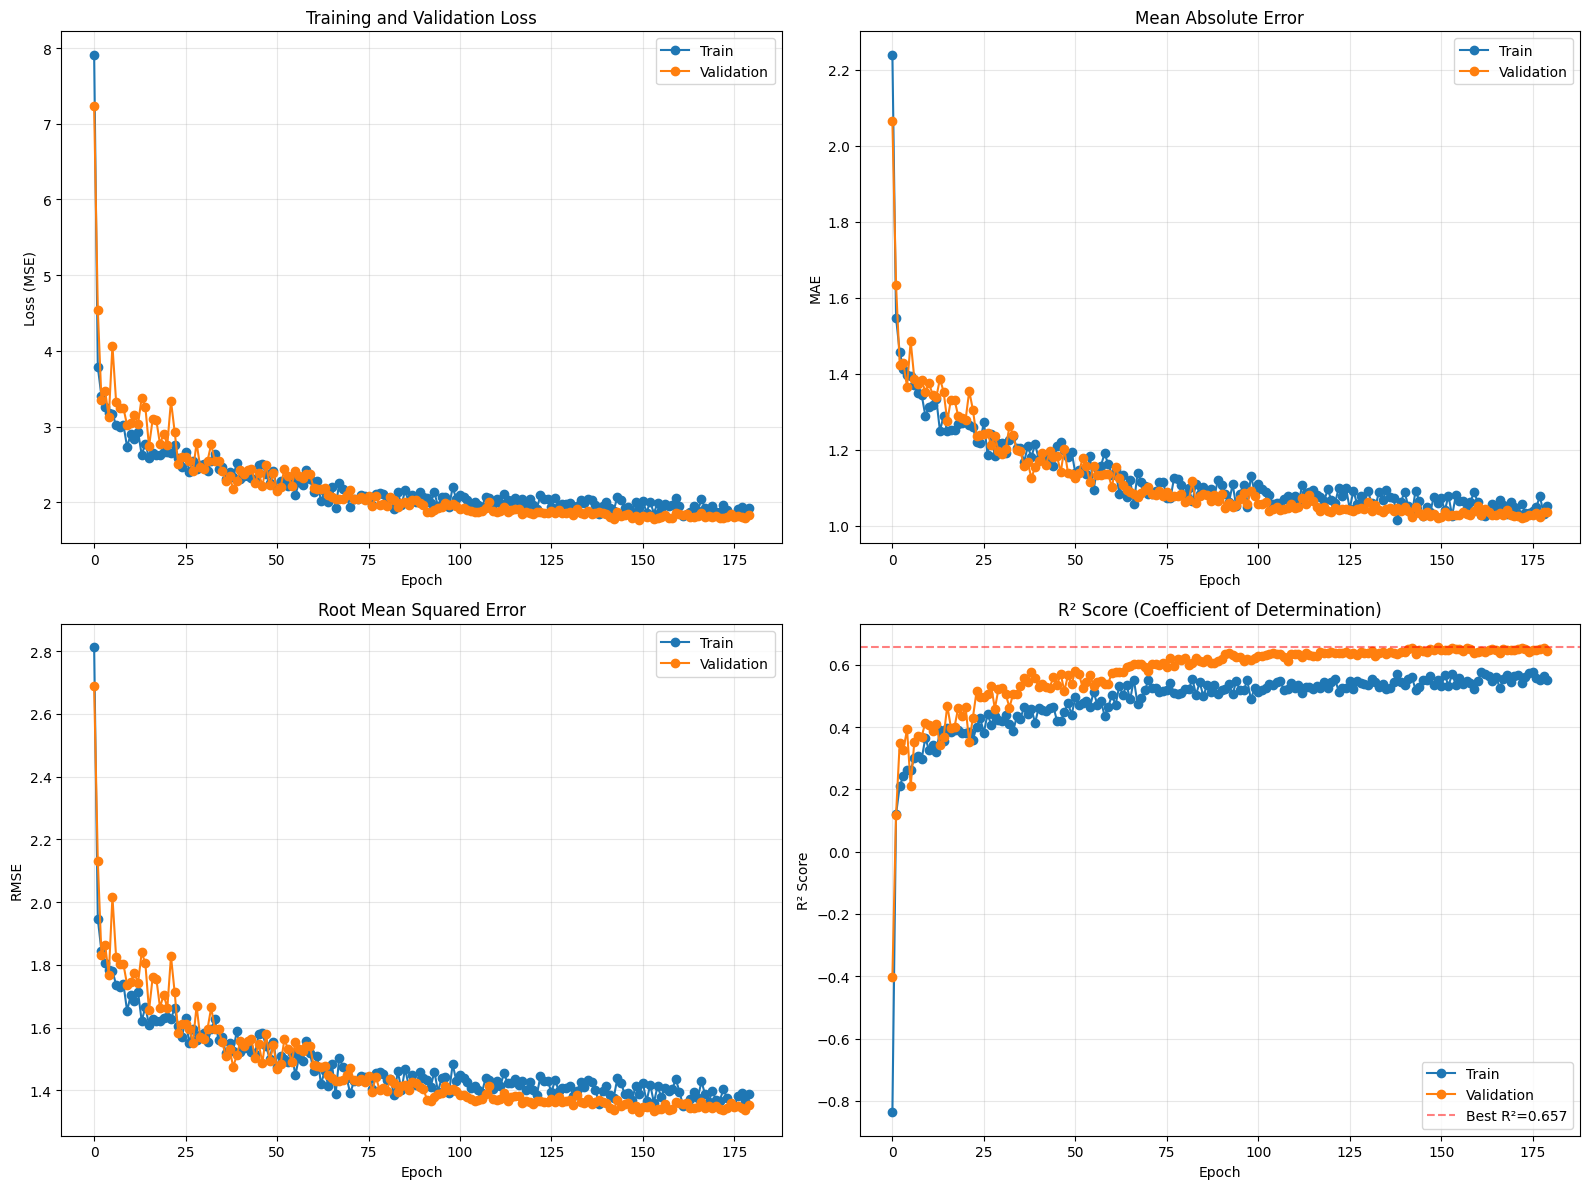


✓ Training curves saved: drug_discovery_training_curves.png


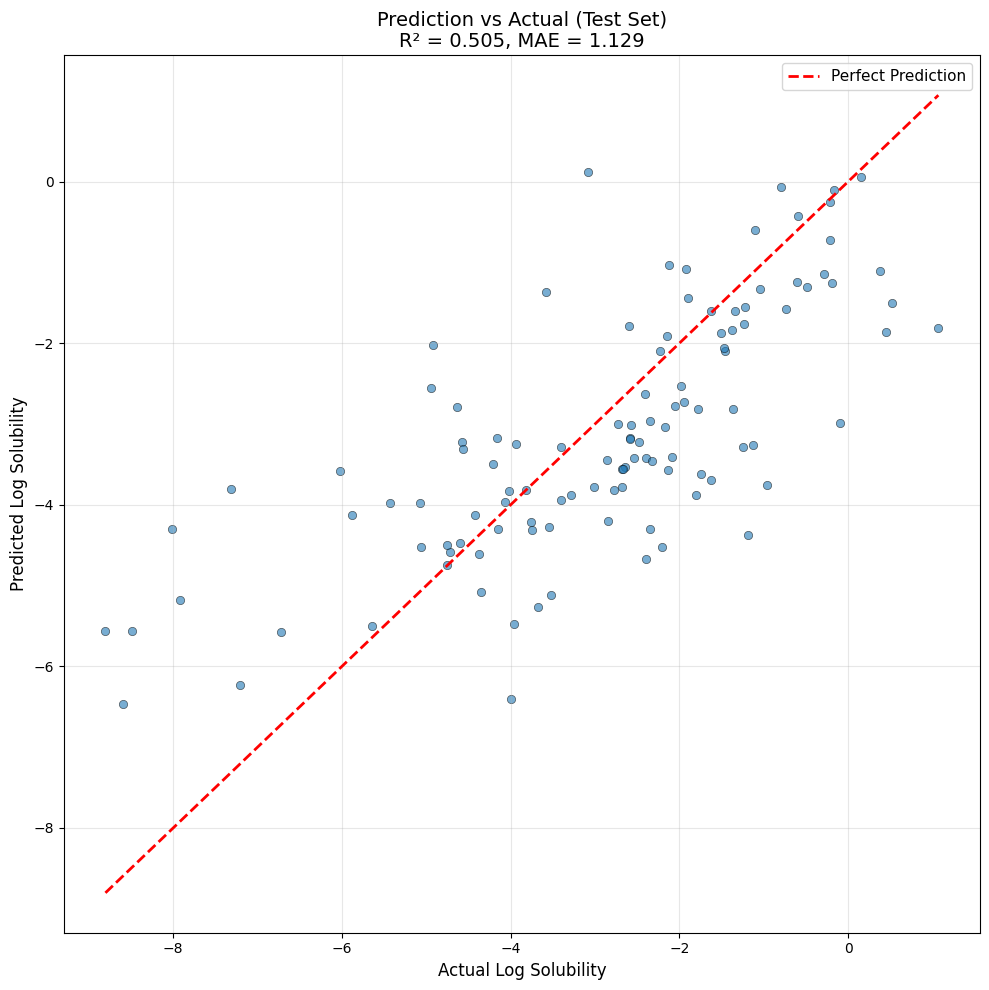

✓ Prediction plot saved: drug_discovery_predictions.png

MODEL PERFORMANCE SUMMARY

Metric               Train           Validation      Test           
----------------------------------------------------------------------
R² Score             0.5521          0.6571          0.5050         
MAE                  1.0526          1.0215          1.1287         
RMSE                 1.3889          1.3294          1.4516         

🎉 DRUG DISCOVERY MODEL TRAINING COMPLETE!


In [15]:
import matplotlib.pyplot as plt

print("="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate on test set
test_loss, test_mae, test_rmse, test_r2, test_preds, test_targets = validate_epoch(
    model, test_loader, criterion, device
)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(history['val_loss'], label='Validation', marker='o')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history['train_mae'], label='Train', marker='o')
axes[0, 1].plot(history['val_mae'], label='Validation', marker='o')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# RMSE
axes[1, 0].plot(history['train_rmse'], label='Train', marker='o')
axes[1, 0].plot(history['val_rmse'], label='Validation', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Root Mean Squared Error')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# R²
axes[1, 1].plot(history['train_r2'], label='Train', marker='o')
axes[1, 1].plot(history['val_r2'], label='Validation', marker='o')
axes[1, 1].axhline(y=best_r2, color='red', linestyle='--', alpha=0.5, label=f'Best R²={best_r2:.3f}')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('R² Score (Coefficient of Determination)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('drug_discovery_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training curves saved: drug_discovery_training_curves.png")

# Prediction vs Actual plot
plt.figure(figsize=(10, 10))
plt.scatter(test_targets, test_preds, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Log Solubility', fontsize=12)
plt.ylabel('Predicted Log Solubility', fontsize=12)
plt.title(f'Prediction vs Actual (Test Set)\nR² = {test_r2:.3f}, MAE = {test_mae:.3f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('drug_discovery_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction plot saved: drug_discovery_predictions.png")

print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"\n{'Metric':<20} {'Train':<15} {'Validation':<15} {'Test':<15}")
print("-"*70)
print(f"{'R² Score':<20} {history['train_r2'][-1]:<15.4f} {best_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'MAE':<20} {history['train_mae'][-1]:<15.4f} {min(history['val_mae']):<15.4f} {test_mae:<15.4f}")
print(f"{'RMSE':<20} {history['train_rmse'][-1]:<15.4f} {min(history['val_rmse']):<15.4f} {test_rmse:<15.4f}")
print("="*70)

print("\n🎉 DRUG DISCOVERY MODEL TRAINING COMPLETE!")